In [96]:
import os, sys
import numpy as np
import pandas as pd
import SimpleITK as sitk
from scipy import ndimage as ndi
from skimage import filters
from skimage import measure
import skimage
import pydicom
import matplotlib.pyplot as plt
%matplotlib inline

In [99]:
import SimpleITK as sitk

# ref https://gist.github.com/pangyuteng/7f54dbfcd67fb9d43a85f8c6818fca7b
def imread(fpath):
    if os.path.isdir(fpath):
        dicom_names = [os.path.join(fpath,x) for x in os.listdir(fpath)]
        mylist = []
        for x in dicom_names:
            ds = pydicom.dcmread(x)
            mylist.append( (ds.InstanceNumber,x))
        
        dicom_names = [x[1] for x in sorted(mylist,key=lambda x: x[0])]
        reader = sitk.ImageSeriesReader()
        reader.SetFileNames(dicom_names)
    else:
        reader= sitk.ImageFileReader()
        reader.SetFileName(fpath)
    img = reader.Execute()
    arr = sitk.GetArrayFromImage(img)    
    spacing = img.GetSpacing()
    origin = img.GetOrigin()
    direction = img.GetDirection()
    return img

def imwrite(fpath,arr,spacing,origin,direction,use_compression=True):
    img = sitk.GetImageFromArray(arr)
    img.SetSpacing(spacing)
    img.SetOrigin(origin)
    img.SetDirection(direction)
    writer = sitk.ImageFileWriter()    
    writer.SetFileName(fpath)
    writer.SetUseCompression(use_compression)
    writer.Execute(img)

# ref https://gist.github.com/mrajchl/ccbd5ed12eb68e0c1afc5da116af614a
def resample_img(itk_image,origin,direction):
    
    # Resample images to out_spacing with SimpleITK
    original_spacing = itk_image.GetSpacing()
    original_size = itk_image.GetSize()
    
    out_spacing=[1.0, 1.0, 1.0]
    out_size = [
        int(np.round(original_size[0] * (original_spacing[0] / out_spacing[0]))),
        int(np.round(original_size[1] * (original_spacing[1] / out_spacing[1]))),
        int(np.round(original_size[2] * (original_spacing[2] / out_spacing[2])))]

    resample = sitk.ResampleImageFilter()
    resample.SetOutputSpacing(out_spacing)
    resample.SetSize(out_size)
    resample.SetOutputDirection(direction)
    resample.SetOutputOrigin(origin)
    resample.SetTransform(sitk.Transform())
    resample.SetDefaultPixelValue(itk_image.GetPixelIDValue())
    
    sampler = None
    if sampler == 'nearest':
        resample.SetInterpolator(sitk.sitkNearestNeighbor)
    else:
        resample.SetInterpolator(sitk.sitkBSpline)

    return resample.Execute(itk_image)


In [100]:
import os
import requests
local_filename = 'img.zip'
if not os.path.exists(local_filename):
    uid = "1.3.6.1.4.1.14519.5.2.1.6279.6001.113679818447732724990336702075"
    r=requests.get(f"https://services.cancerimagingarchive.net/services/v4/TCIA/query/getImage?SeriesInstanceUID={uid}")
    if r.status_code == 200:
        with open(local_filename, 'wb') as f:
            for chunk in r.iter_content(chunk_size=1024): 
                if chunk: # filter out keep-alive new chunks
                    f.write(chunk)

    del r

In [101]:
# !mkdir -p img && unzip img.zip -d img

In [159]:
itk_image = imread('img')

(0.609375, 0.609375, 1.25) (-146.7, -152.2, 7.5) (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0) (512, 512, 241)


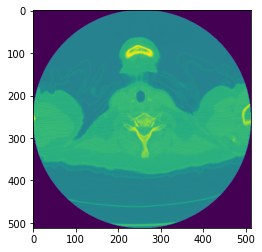

In [161]:
arr = sitk.GetArrayFromImage(itk_image)    
spacing = itk_image.GetSpacing()
origin = itk_image.GetOrigin()
direction = itk_image.GetDirection()
size = itk_image.GetSize()

print(spacing,origin,direction,size)

plt.imshow(arr[0,:,:].squeeze())

(4.875, 4.875, 10.0) (-146.7, -152.2, 7.5) (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0) (64, 64, 64)


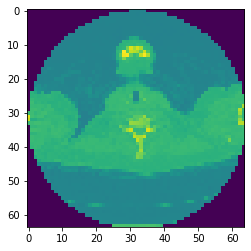

In [196]:
origin = (-146.7, -152.2, 7.5)
spacing = (8*0.609375, 8*0.609375, 8*1.25)
size = (64,64,64)
direction = (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)

resample = sitk.ResampleImageFilter()
resample.SetOutputSpacing(spacing)
resample.SetSize(size)
resample.SetOutputDirection(direction)
resample.SetOutputOrigin(origin)
resample.SetTransform(sitk.Transform())
resample.SetDefaultPixelValue(itk_image.GetPixelIDValue())
resample.SetInterpolator(sitk.sitkBSpline)
new_img = resample.Execute(itk_image)


arr = sitk.GetArrayFromImage(new_img)
spacing = new_img.GetSpacing()
origin = new_img.GetOrigin()
direction = new_img.GetDirection()
size = new_img.GetSize()

print(spacing,origin,direction,size)

plt.imshow(arr[0,:,:].squeeze())

(4.875, 4.875, 10.0) (-146.7, -152.2, 7.5) (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.7, 0.7) (64, 64, 64)


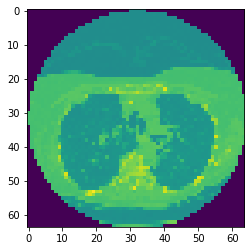

In [207]:
origin = (-146.7, -152.2, 7.5)
spacing = (8*0.609375, 8*0.609375, 8*1.25)
size = (64,64,64)
direction = (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.7, 0.7)

resample = sitk.ResampleImageFilter()
resample.SetOutputSpacing(spacing)
resample.SetSize(size)
resample.SetOutputDirection(direction)
resample.SetOutputOrigin(origin)
resample.SetTransform(sitk.Transform())
resample.SetDefaultPixelValue(new_img.GetPixelIDValue())
resample.SetInterpolator(sitk.sitkNearestNeighbor)
oblique_img = resample.Execute(new_img)

arr = sitk.GetArrayFromImage(oblique_img)
spacing = oblique_img.GetSpacing()
origin = oblique_img.GetOrigin()
direction = oblique_img.GetDirection()
size = oblique_img.GetSize()

print(spacing,origin,direction,size)

plt.imshow(arr[0,:,:].squeeze())